In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# view the data 
df = pd.read_csv("london_energy.csv")

# sanity check
print(df.isna().sum())

# view the data 
df.head()

LCLid    0
Date     0
KWH      0
dtype: int64


,LCLid,Date,KWH
0,MAC000002,2012-10-12,7.098
1,MAC000002,2012-10-13,11.087
2,MAC000002,2012-10-14,13.223
3,MAC000002,2012-10-15,10.257
4,MAC000002,2012-10-16,9.769


##### That’s why we choose to enhance our dataset with weather data from the London Weather Dataset.

In [3]:
# read the weather data ]
df_weather = pd.read_csv("london_weather.csv")

# sanity check  
print(df_weather.isna().sum())

# sanity check - display 
df_weather.head()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [4]:
df_avg_consumption = df.groupby("Date")["KWH"].mean() # gives mean for each date 
df_avg_consumption = pd.DataFrame({"date": df_avg_consumption.index.tolist(), "consumption": df_avg_consumption.values.tolist()})
df_avg_consumption["date"] = pd.to_datetime(df_avg_consumption["date"]) # convert colunmn from series to datetime object for TS analysis 
print(f"From: {df_avg_consumption['date'].min()}")
print(f"To: {df_avg_consumption['date'].max()}")

From: 2011-11-23 00:00:00
To: 2014-02-28 00:00:00


##### There are various missing data that need to be filled in. Filling missing data is not trivial and depends on each case. Since we have weather data where each day depends on the previous and next days, we will fill those values by interpolating. Also, we will convert the `date` column to `datetime` and, then, merge the two dataframes in order to get one enhanced dataframe.

In [5]:
# Parsing dates
df_weather["date"] = pd.to_datetime(df_weather["date"], format="%Y%m%d")

# Filling missing values through interpolation
df_weather = df_weather.interpolate(method="ffill")

# Enhancing consumption dataset with weather information
df_avg_consumption = df_avg_consumption.merge(df_weather, how="inner", on="date")
df_avg_consumption.head()

/var/folders/mh/crzr9fvs1hz479vjn820n9kc0000gq/T/ipykernel_2214/2083148899.py:5: FutureWarning: DataFrame.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_weather = df_weather.interpolate(method="ffill")


,date,consumption,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,2011-11-23,6.952692,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0
1,2011-11-24,8.536480,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0
2,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0
3,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0
4,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0


In [6]:
df_avg_consumption["day_of_week"] = df_avg_consumption["date"].dt.dayofweek
df_avg_consumption["day_of_year"] = df_avg_consumption["date"].dt.dayofyear
df_avg_consumption["month"] = df_avg_consumption["date"].dt.month
df_avg_consumption["quarter"] = df_avg_consumption["date"].dt.quarter
df_avg_consumption["year"] = df_avg_consumption["date"].dt.year

df_avg_consumption.head()

,date,consumption,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth,day_of_week,day_of_year,month,quarter,year
0,2011-11-23,6.952692,7.0,2.0,35.0,13.5,6.8,2.6,0.2,102720.0,0.0,2,327,11,4,2011
1,2011-11-24,8.536480,3.0,2.0,35.0,12.5,8.6,3.7,0.2,102710.0,0.0,3,328,11,4,2011
2,2011-11-25,9.499781,3.0,5.0,52.0,14.0,11.0,9.5,0.0,102450.0,0.0,4,329,11,4,2011
3,2011-11-26,10.267707,4.0,0.7,24.0,13.9,10.2,6.3,0.0,102580.0,0.0,5,330,11,4,2011
4,2011-11-27,10.850805,3.0,5.9,55.0,13.2,11.8,9.7,0.0,102130.0,0.0,6,331,11,4,2011


In [7]:
training_mask = df_avg_consumption["date"] < "2013-07-28"
training_data = df_avg_consumption.loc[training_mask]
print(training_data.shape)

testing_mask = df_avg_consumption["date"] >= "2013-07-28"
testing_data = df_avg_consumption.loc[testing_mask]
print(testing_data.shape)

(613, 16)
(216, 16)


In [8]:
# Dropping unnecessary `date` column
training_data = training_data.drop(columns=["date"])
testing_dates = testing_data["date"]
testing_data = testing_data.drop(columns=["date"])

X_train = training_data[["day_of_week", "day_of_year", "month", "quarter", "year",\
                         "cloud_cover", "sunshine", "global_radiation", "max_temp",\
                         "mean_temp", "min_temp", "precipitation", "pressure",\
                         "snow_depth"]]
y_train = training_data["consumption"]


X_test = testing_data[["day_of_week", "day_of_year", "month", "quarter", "year",\
                         "cloud_cover", "sunshine", "global_radiation", "max_temp",\
                         "mean_temp", "min_temp", "precipitation", "pressure",\
                         "snow_depth"]]
y_test = testing_data["consumption"]

In [9]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impo...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

##### For evaluation we will use Mean Absolute Error or MAE, the Mean Squared Error or MSE and the Mean Absolute Percentage Error or MAPE. Each of these provide a different perspective on the actual performance of the trained model. 

In [10]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

##### Lastly, to evaluate any of the aforementioned models we have to run the following:

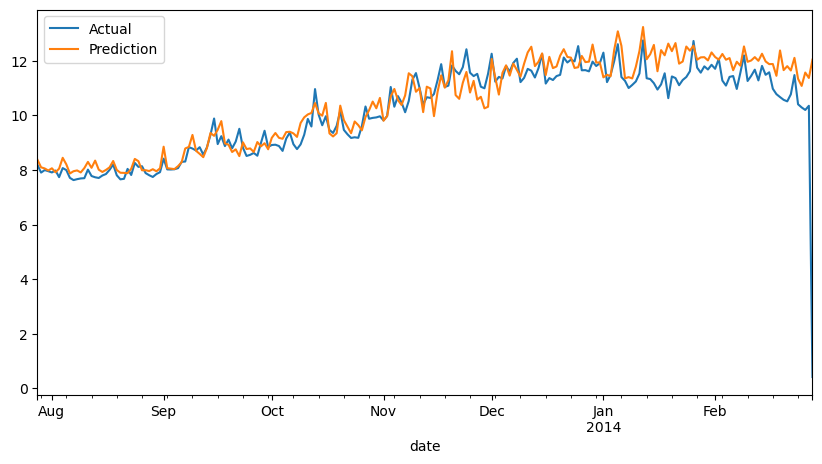

MAE: 0.47940389041017006
MSE: 0.92609194038901
MAPE: 0.16954584075848292


In [11]:
# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)